In [1]:
!pip install --quiet transformers datasets evaluate accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.5 MB/s eta 0:00:00


In [2]:
!gdown 1oUKScMHKFS0UfgVVbb1sPpcF_B4BNco4 -O dataset.zip
!unzip -o dataset.zip -d dataset
!rm dataset.zip

Downloading...
From: https://drive.google.com/uc?id=1oUKScMHKFS0UfgVVbb1sPpcF_B4BNco4
To: /content/dataset.zip
100% 503k/503k [00:00<00:00, 5.30MB/s]
Archive:  dataset.zip
  inflating: dataset/test.csv        
  inflating: dataset/train.csv       


In [3]:
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate
from datasets import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-fa-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/440 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.20M [00:00<?, ?B/s]

In [5]:
# def preprocess_function(dataframe):
#     return tokenizer(dataframe["text"].tolist(), padding=True, truncation=True, return_tensors="pt")
def preprocess_function(data):
    for i in range(len(data["label"])):
      data["label"][i]=label2id[data["label"][i]]
    return tokenizer(data["text"], truncation=True,padding=True,max_length=50, add_special_tokens = True)

In [6]:
TRAIN_FILE="dataset/train.csv"
TEST_FILE="dataset/test.csv"

In [7]:
train_df= pd.read_csv(TRAIN_FILE)
# test_df= pd.read_csv(TEST_FILE)

In [8]:
dataset = load_dataset('csv', data_files={'train': TRAIN_FILE,'test': TEST_FILE})

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [9]:
id2label = {}
label2id = {}
#TODO: use dataset["train"]["label"].unique()
emotions=train_df["label"].unique()
index=0
for emotion in emotions:
  id2label[index]=emotion
  label2id[emotion]=index
  index+=1
num_classes=len(emotions)

In [10]:
tokenized_dataset = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/6125 [00:00<?, ? examples/s]

Map:   0%|          | 0/1151 [00:00<?, ? examples/s]

In [11]:
tokenized_dataset["train"][2]

{'text': '" کیفیتش خیلی خوبه با شک خریدم ولی واقعا راضیم بعد از حدود 2 ماه استفاده « متاسفانه باخبر شدیم » که فردی در ایرانشهر به حداقل 41 دختر تجاوز کرده . امیدواریم با همکاری نمایندگان محترم مجلس و دستگاه قضا ، دیگه به این راحتی باخبر نشیم .',
 'label': 0,
 'input_ids': [2,
  1002,
  73833,
  3805,
  27841,
  2799,
  3079,
  38993,
  3362,
  5668,
  8629,
  2015,
  3082,
  2791,
  3400,
  1,
  3125,
  2988,
  1064,
  5571,
  17050,
  9003,
  1078,
  2800,
  5079,
  2786,
  18352,
  2789,
  4722,
  1,
  4714,
  8374,
  3027,
  1012,
  8020,
  2799,
  3909,
  5098,
  8496,
  3590,
  1379,
  3698,
  6196,
  1348,
  11904,
  2789,
  2802,
  5842,
  17050,
  4],
 'token_type_ids': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,


In [12]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [13]:
model = AutoModelForSequenceClassification.from_pretrained(
    "HooshvareLab/bert-fa-base-uncased", num_labels=num_classes, id2label=id2label, label2id=label2id
)

pytorch_model.bin:   0%|          | 0.00/654M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-fa-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
accuracy = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [15]:
training_args = TrainingArguments(
    output_dir="my_awesome_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=20,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
)

In [16]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [17]:
trainer.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.118050,0.630756
2,1.169400,1.045267,0.648132
3,0.616600,1.329898,0.608167
4,0.308900,1.574990,0.618593
5,0.308900,1.742687,0.634231
6,0.126600,2.194758,0.612511
7,0.064200,2.325243,0.636838
8,0.039900,2.550015,0.622068
9,0.039900,2.837571,0.602954
10,0.027600,3.081619,0.594266


TrainOutput(global_step=7660, training_loss=0.15995690758794778, metrics={'train_runtime': 1805.4812, 'train_samples_per_second': 67.849, 'train_steps_per_second': 4.243, 'total_flos': 3147710081250000.0, 'train_loss': 0.15995690758794778, 'epoch': 20.0})

In [69]:
def predict(text,model,tokenizer):
  inputs = tokenizer(text, return_tensors="pt")
  # with torch.no_grad():
  print(trainer.predict(inputs))
  logits = model(**inputs).logits
  predicted_class_id = logits.argmax().item()
  return model.config.id2label[predicted_class_id]


In [42]:
text="امروز چه روز غم انگیزیه"

In [70]:
trainer.predict(text)

AttributeError: 'list' object has no attribute 'keys'

In [68]:
predict(text,model,tokenizer)

IndexError: list index out of range

In [65]:
history=pd.DataFrame(trainer.state.log_history)

,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,step,loss,learning_rate,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,1.118050,0.630756,3.3575,342.819,21.445,1.00,383,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,1.31,500,1.1694,1.869452e-05,NaN,NaN,NaN,NaN,NaN
2,1.045267,0.648132,3.4800,330.749,20.690,2.00,766,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,2.61,1000,0.6166,1.738903e-05,NaN,NaN,NaN,NaN,NaN
4,1.329898,0.608167,3.4878,330.010,20.644,3.00,1149,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,3.92,1500,0.3089,1.608355e-05,NaN,NaN,NaN,NaN,NaN
6,1.574990,0.618593,3.5535,323.910,20.262,4.00,1532,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1.742687,0.634231,3.5655,322.818,20.194,5.00,1915,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,5.22,2000,0.1266,1.477807e-05,NaN,NaN,NaN,NaN,NaN
9,2.194758,0.612511,3.5545,323.819,20.256,6.00,2298,NaN,NaN,NaN,NaN,NaN,NaN,NaN


from matplotlib import pyplot as plt
history['eval_loss'].plot(kind='hist', bins=20, title='eval_loss')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
history['eval_accuracy'].plot(kind='hist', bins=20, title='eval_accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
history['eval_runtime'].plot(kind='hist', bins=20, title='eval_runtime')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
history['eval_samples_per_second'].plot(kind='hist', bins=20, title='eval_samples_per_second')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
history.plot(kind='scatter', x='eval_loss', y='eval_accuracy', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
history.plot(kind='scatter', x='eval_accuracy', y='eval_runtime', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
history.plot(kind='scatter', x='eval_runtime', y='eval_samples_per_second', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
history.plot(kind='scatter', x='eval_samples_per_second', y='eval_steps_per_second', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['eval_runtime']
  ys = series['eval_loss']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = history.sort_values('eval_runtime', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('eval_runtime')
_ = plt.ylabel('eval_loss')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['eval_runtime']
  ys = series['eval_accuracy']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = history.sort_values('eval_runtime', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('eval_runtime')
_ = plt.ylabel('eval_accuracy')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['eval_runtime']
  ys = series['eval_samples_per_second']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = history.sort_values('eval_runtime', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('eval_runtime')
_ = plt.ylabel('eval_samples_per_second')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['eval_runtime']
  ys = series['eval_steps_per_second']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = history.sort_values('eval_runtime', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('eval_runtime')
_ = plt.ylabel('eval_steps_per_second')

from matplotlib import pyplot as plt
history['eval_loss'].plot(kind='line', figsize=(8, 4), title='eval_loss')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
history['eval_accuracy'].plot(kind='line', figsize=(8, 4), title='eval_accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
history['eval_runtime'].plot(kind='line', figsize=(8, 4), title='eval_runtime')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
history['eval_samples_per_second'].plot(kind='line', figsize=(8, 4), title='eval_samples_per_second')
plt.gca().spines[['top', 'right']].set_visible(False)

In [53]:
val_acc=history[["epoch","eval_accuracy"]].dropna()
val_loss=history[["epoch","eval_loss"]].dropna()
train_loss=history[["epoch","loss"]].dropna()
learning_rates=history[["epoch","learning_rate"]].dropna()

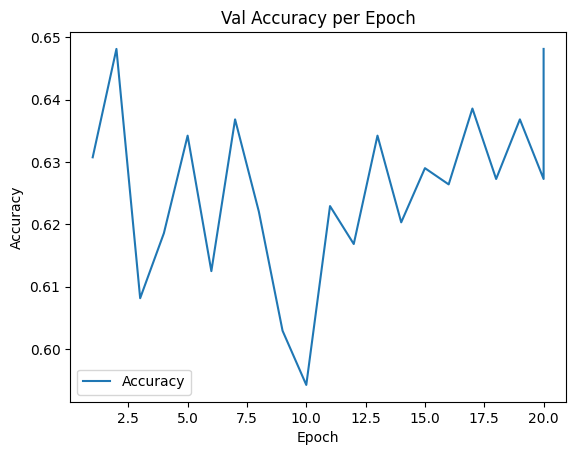

In [58]:
plt.plot(val_acc["epoch"],val_acc["eval_accuracy"], label="Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Val Accuracy per Epoch")
plt.legend()
plt.show()

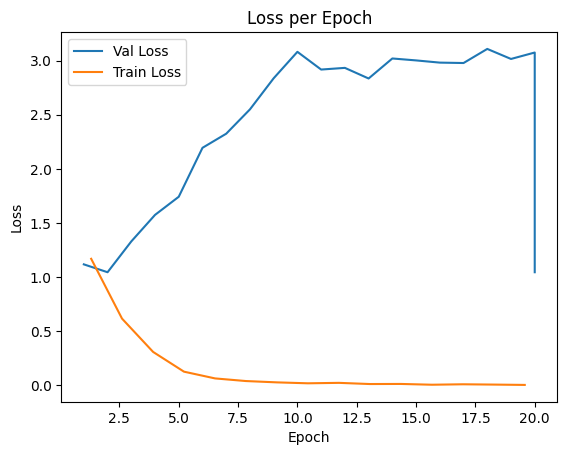

In [62]:
plt.plot(val_loss["epoch"],val_loss["eval_loss"], label="Val Loss")
plt.plot(train_loss["epoch"],train_loss["loss"], label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()
plt.show()

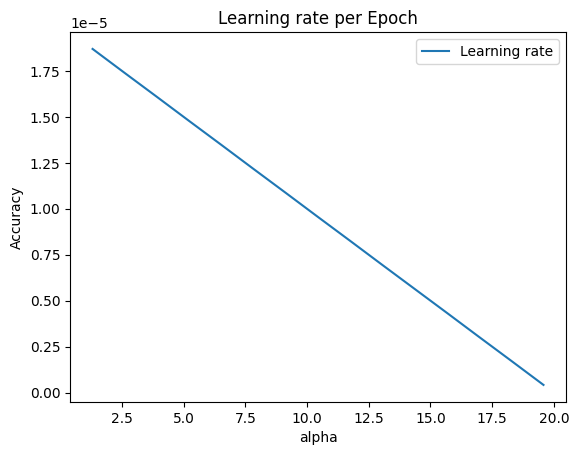

In [63]:
plt.plot(learning_rates["epoch"],learning_rates["learning_rate"], label="Learning rate")
plt.xlabel("alpha")
plt.ylabel("Accuracy")
plt.title("Learning rate per Epoch")
plt.legend()
plt.show()